In [11]:
#### Import ENV Variables

import os
from dotenv import load_dotenv
load_dotenv()

True

##### ### Import Various Tools 

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

## Using Arxiv Tool
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

##Using WikiPedia Tool
wikipedia_api_wrapper = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)

## Using Tavily Tool
tavily = TavilySearchResults()

##### Combine all The Tools

In [13]:
tools = [arxiv,wikipedia,tavily]
tools

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\LangGraphSeries\\module01\\venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=2, lang='en', load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))]

#### Import the LLM Model

In [14]:
from langchain_groq import ChatGroq

model = ChatGroq(model="llama-3.1-8b-instant")

#### Bind the Tools with LLM

In [15]:
llm_with_tools = model.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000237FA106E40>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000237FA106990>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look

##### Create a ChatBot using LangGraph

In [16]:
### Define the State
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [18]:
#### Define The Node
def calling_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#### Create a Complete Graph Construction


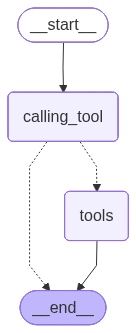

In [20]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
##Build a Graph
graph = StateGraph(State)

## Add a Nodes
graph.add_node("calling_tool",calling_tool)
graph.add_node("tools",ToolNode(tools))

## Add a Edges
graph.add_edge(START,"calling_tool")
graph.add_conditional_edges("calling_tool",tools_condition)
graph.add_edge("tools",END)

##Compile the graph
graph_builder = graph.compile()

## Draw The Graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [21]:
from langchain_core.messages import HumanMessage
messages = graph_builder.invoke({"messages":HumanMessage(content="What is Attention all you need")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is Attention all you need
================================== Ai Message ==================================
Tool Calls:
  wikipedia (np71rcwa0)
 Call ID: np71rcwa0
  Args:
    query: Attention all you need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [22]:
from langchain_core.messages import HumanMessage
messages = graph_builder.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (6pkvf12hd)
 Call ID: 6pkvf12hd
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base
